# Targets for Abi

She's on at Magellan June 3 and 22, 2022, and needs second-half-night targets.

| field | ra | dec|
|------------|--------|----------|
|COSMOS-1    | 150.0  |  3.1     |
|COSMOS-2    | 149.22 | 1.75     |
|COSMOS-3    | 150.78 | 1.75     |
|DECaPS-East | 270.89 | -29.53   |
|ELAIS-E1    | 7.8746 | -43.0096 |
|ELAIS-E2    | 9.5    | -43.9980 |
|DECaPS-West | 116.32 | -26.25   |

# try for ELAIS

In [1]:
import psycopg2
import psycopg2.extras
import getpass
# from IPython.display import display
# import ipywidgets

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# import pandas as pd

from copy import deepcopy
import time
from astropy.time import Time

font = {'size' : 15}
mpl.rc('font', **font)

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

DB User:  mgraham
DB Password:  ············


In [3]:
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

In [4]:
### If you want to print table schema
# tables = ['exposures','subtractions','objects','objectrbs','candidates']
# tables = ['exposures','subtractions','objects','candidates']
# for table in tables:
#     query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name=%s"
#     cursor.execute( query, ( table, ))
#     print( f"\nTABLE: {table}\n===========================" )
#     for row in cursor:
#         print( f"{row['column_name']:24s}  :  {row['data_type']:s}" )

### Look for recent candidates in ELAIS

|ELAIS-E1    | 7.8746 | -43.0096 |

|ELAIS-E2    | 9.5    | -43.9980 |


In [5]:
t1 = time.time()

query = ("SELECT id, ra, dec, created_at, modified FROM candidates "
         "WHERE ra > 6 AND ra < 11 AND dec < -41 AND dec > -45")

cursor.execute( query )
results = np.array( cursor.fetchall() ).transpose()

t2 = time.time()
print(t2-t1)
del t1,t2

cand_id       = np.asarray( results[0] )
cand_ra       = np.asarray( results[1], dtype='float' )
cand_dec      = np.asarray( results[2], dtype='float' )
cand_created  = np.asarray( results[3], dtype='str' )
cand_modified = np.asarray( results[4], dtype='str' )
del query, results

print(len(cand_id))

7.104093313217163
349422


In [6]:
print('Dates of ELAIS candidates, first and last created.')
sx = np.argsort( cand_created )
print(cand_created[sx[0]])
print(cand_created[sx[-1]])
print(' ')
print('Dates of ELAIS candidates, first and last modified.')
sx = np.argsort( cand_modified )
print(cand_modified[sx[0]])
print(cand_modified[sx[-1]])
print(' ')

Dates of ELAIS candidates, first and last created.
2021-06-02 16:39:46.635790
2022-06-20 19:27:36.589931
 
Dates of ELAIS candidates, first and last modified.
2021-06-02 16:39:46.635790
2022-06-20 19:27:36.589931
 


### Look for recent objects in ELAIS

Tue Jun 21 is 59752.

In [61]:
t1 = time.time()

query = ("SELECT o.id, o.ra, o.dec, o.candidate_id, o.subtraction_id, o.mag, o.magerr, "
         "rbs.rb, sub.exposure_id, exp.mjd, exp.filter "
         "FROM objects AS o "
         "JOIN objectrbs AS rbs ON o.id=rbs.object_id AND rbs.rbtype_id=2 "
         "JOIN subtractions AS sub ON sub.id=o.subtraction_id "
         "JOIN exposures AS exp ON exp.id=sub.exposure_id "
         "WHERE o.ra > 5 AND o.ra < 12 AND o.dec < -40 AND o.dec > -46 "
         "AND exp.mjd > 59710")
cursor.execute( query )
results = np.array( cursor.fetchall() ).transpose()

t2 = time.time()
print(t2-t1)
del t1,t2

obj_id     = np.asarray( results[0], dtype='int' )
obj_ra     = np.asarray( results[1], dtype='float' )
obj_dec    = np.asarray( results[2], dtype='float' )
obj_candid = np.asarray( results[3] )
obj_subid  = np.asarray( results[4], dtype='int' )
obj_mag    = np.asarray( results[5], dtype='float' )
obj_magerr = np.asarray( results[6], dtype='float' )
obj_rb     = np.asarray( results[7], dtype='float' )
obj_expid  = np.asarray( results[8], dtype='int' )
obj_mjd    = np.asarray( results[9], dtype='float' )
obj_filter = np.asarray( results[10] )

del query, results

print('Number of objects: ', len(obj_id))

18.97088074684143
Number of objects:  43140


### Identify unique candidates with > N counts

In [62]:
u_candid, indices, counts =  np.unique( np.sort( obj_candid ), return_index=True, return_counts=True )

In [63]:
print('Number of candidates, total: ', len(u_candid))
print('should match: ',len(counts))

Number of candidates, total:  35166
should match:  35166


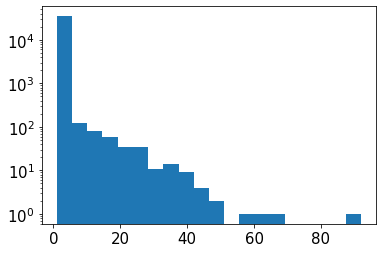

In [64]:
plt.hist(counts, bins=20, log=True)
plt.show()

In [65]:
tx = np.where(counts > 30)[0]
print('Number of candidates with >10 objects: ', len(tx))
temp_id = np.asarray(u_candid[tx], dtype='str')
temp_ct = np.asarray(counts[tx], dtype='float')
del tx

Number of candidates with >10 objects:  36


Calculate the mean rb score for our candidates

In [66]:
temp = []
for i in range(len(temp_id)):
    tx = np.where(obj_candid == temp_id[i])[0]
    temp.append(np.mean(obj_rb[tx]))
    del tx
temp_mrb = np.asarray(temp, dtype='float')
del temp

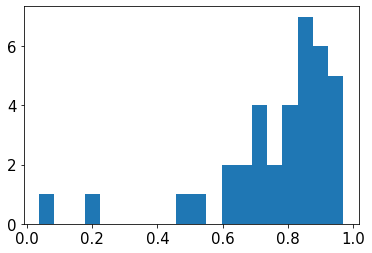

In [67]:
plt.hist(temp_mrb, bins=20)
plt.show()

In [68]:
tx = np.where(temp_mrb > 0.6)[0]
cand_ids = temp_id[tx]
cand_mrb = temp_mrb[tx]
cand_nobj = temp_ct[tx]
del temp_id,temp_mrb,temp_ct

In [69]:
print('Number of potential follow-up targets: ', len(cand_ids))

Number of potential follow-up targets:  31


In [70]:
all_filters = ['g','r','i']
all_fcolors = ['green','red','blue']
all_fshapes = ['o','s','*']
all_fsizes  = [5, 5, 7]

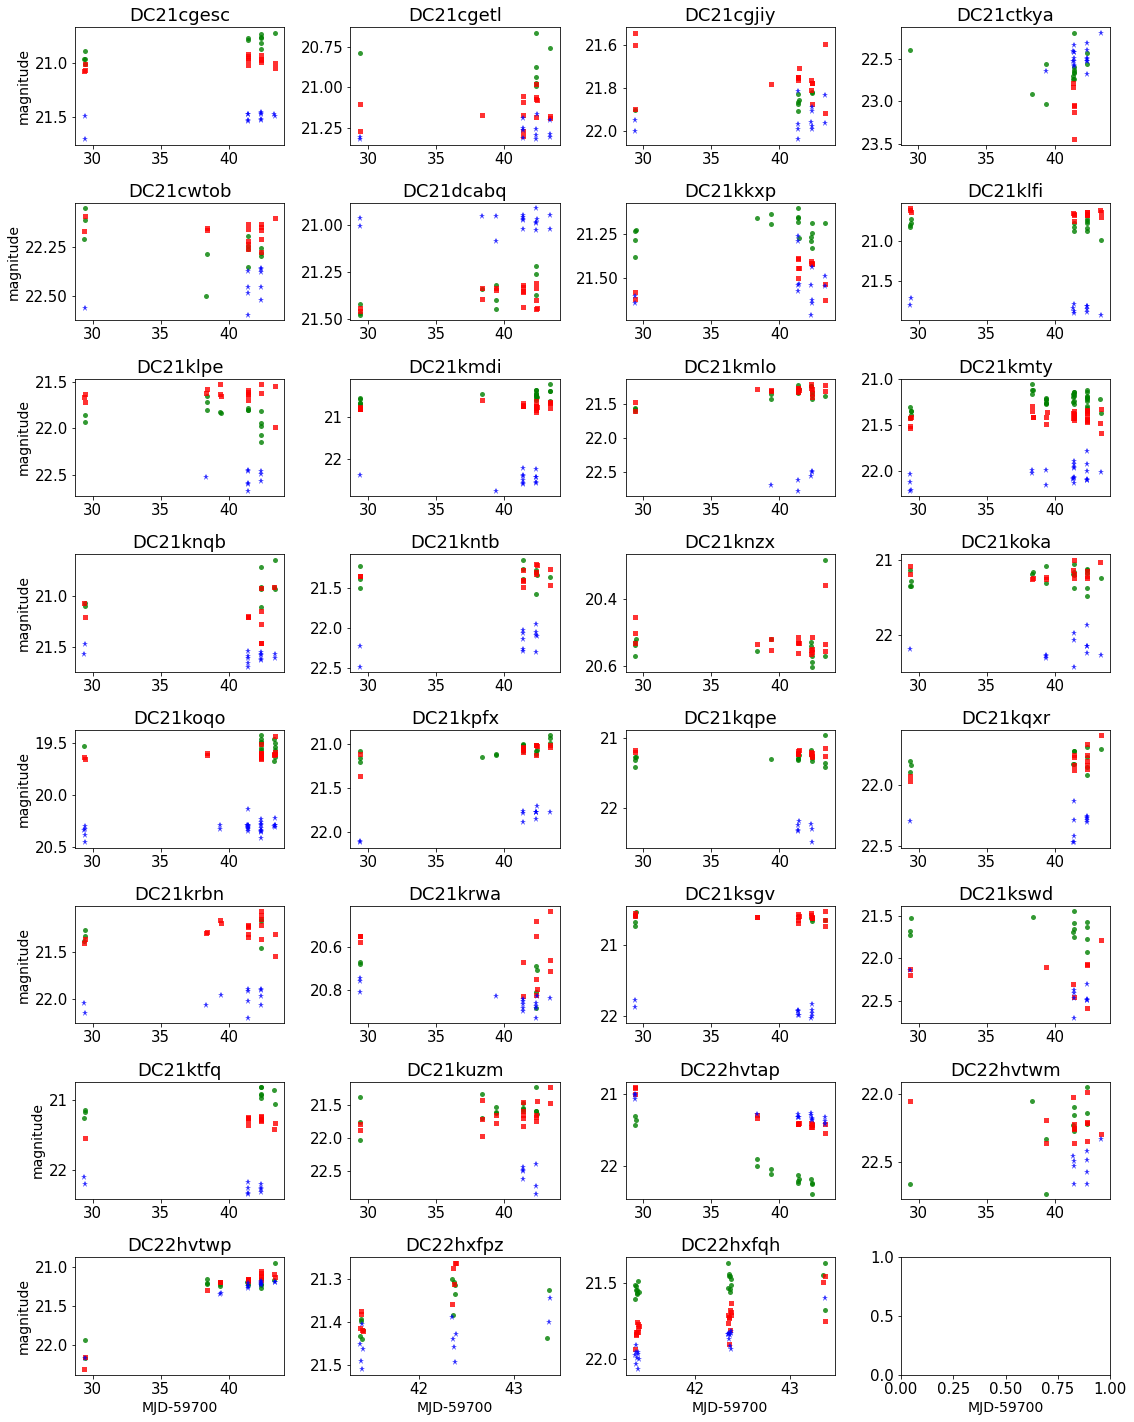

In [72]:
fig, ax = plt.subplots( 8, 4, figsize=(16,20), sharex=False, sharey=False )

t = 0
for i in range(8):
    ax[i,0].set_ylabel('magnitude', fontsize=14)
    for j in range(4):
        if t < len(cand_ids):
            for f,filt in enumerate(all_filters):
                ox = np.where((obj_candid == cand_ids[t]) & (obj_filter == filt))[0]
                ax[i,j].plot(obj_mjd[ox]-59700, obj_mag[ox], all_fshapes[f], 
                             ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f])
                del ox
            ax[i,j].invert_yaxis()
            ax[i,j].set_title(cand_ids[t])
            # ax[i,j].text(0.50, 0.10, cand_ids[t], fontsize=14, color='black', 
            #              verticalalignment='bottom', horizontalalignment='left',
            #              transform=ax[i,j].transAxes)
        t += 1

# ax[0,1].legend(loc='upper right', labelspacing=0.1, handletextpad=0.1, fontsize=14)

for j in range(4):
    ax[7,j].set_xlabel('MJD-59700', fontsize=14)

plt.tight_layout()
plt.show()

del t

In [78]:
targets = np.asarray(['DC21ctkya','DC22hvtwm','DC22hvtap',
                      'DC22hvtwp','DC22hxfqh','DC22hxfpz'], dtype='str')

for t,targ in enumerate(targets):
    ox = np.where(obj_candid == targ)[0]
    print('%-10s %10.6f %10.6f' % (targ, obj_ra[ox[0]], obj_dec[ox[0]]))

DC21ctkya    8.473091 -43.357769
DC22hvtwm    8.652769 -44.760803
DC22hvtap    8.621739 -42.932400
DC22hvtwp    9.149551 -44.267486
DC22hxfqh    8.430943 -43.776315
DC22hxfpz   10.070258 -43.350518


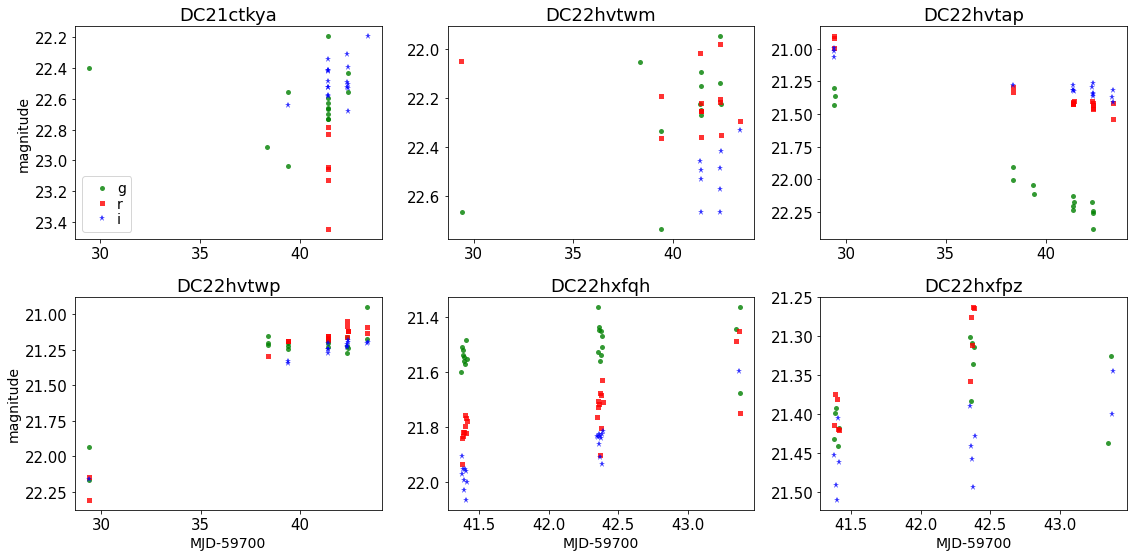

In [76]:

fig, ax = plt.subplots( 2, 3, figsize=(16,8), sharex=False, sharey=False )

t = 0
for i in range(2):
    ax[i,0].set_ylabel('magnitude', fontsize=14)
    for j in range(3):
        if t < len(targets):
            for f,filt in enumerate(all_filters):
                ox = np.where((obj_candid == targets[t]) & (obj_filter == filt))[0]
                ax[i,j].plot(obj_mjd[ox]-59700, obj_mag[ox], all_fshapes[f], 
                             ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f],
                             label=all_filters[f])
                del ox
            ax[i,j].invert_yaxis()
            ax[i,j].set_title(targets[t])
        t += 1

ax[0,0].legend(loc='lower left', labelspacing=0.1, handletextpad=0.1, fontsize=14)

for j in range(3):
    ax[1,j].set_xlabel('MJD-59700', fontsize=14)

plt.tight_layout()
plt.show()

del t